# Forecast kidney diseases

## Goal

The goal of this project will be to read as many stuff of the data as possible and to visualize it as best as possible, the next step will be to prepare a model which will forecast if a person has kidney disease!

But first of all. lets start with the boring stuff, imports and reading the data:

In [68]:
import pandas as pd
import numpy as np
import cufflinks as cf
import plotly.offline as pyo
import seaborn as sns
import matplotlib.pyplot as plt

pyo.init_notebook_mode()
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [69]:
data = pd.read_csv("kidney_disease.csv") 

# Replace them directly at the beginning to have persistent column names
data = data.rename(columns={  "bp": "blood_pressure"
                                                        , "sg": "weight"
                                                        , "al": "albumin"
                                                        , "su": "sugar"
                                                        , "rbc": "red_blood_cells"
                                                        , "pc": "pus_cell"
                                                        , "pcc": "pus_cell_clumps"
                                                        , "ba": "bacteria"
                                                        , "bgr": "blood_glucos_random"
                                                        , "bu": "blood_urea"
                                                        , "sc": "serum_creatinine"
                                                        , "sod": "sodium"
                                                        , "pot": "potassium"
                                                        , "hemo": "hemoglobin"
                                                        , "pcv": "packed_cell_volume"
                                                        , "wc": "white_blood_cell_count"
                                                        , "rc": "red_blood_cell_count"
                                                        , "htn": "hypertension"
                                                        , "dm": "diabetes_mellitus"
                                                        , "cad": "coronary_artery_disease"
                                                        , "appet": "appetite"
                                                        , "pe": "pedal_edema"
                                                        , "ane": "anemia"
})

In [70]:
data[data.columns[0:13]].head()

id   age  blood_pressure  weight  albumin  sugar red_blood_cells  pus_cell  \
0   0  48.0            80.0   1.020      1.0    0.0             NaN    normal   
1   1   7.0            50.0   1.020      4.0    0.0             NaN    normal   
2   2  62.0            80.0   1.010      2.0    3.0          normal    normal   
3   3  48.0            70.0   1.005      4.0    0.0          normal  abnormal   
4   4  51.0            80.0   1.010      2.0    0.0          normal    normal   

  pus_cell_clumps    bacteria  blood_glucos_random  blood_urea  \
0      notpresent  notpresent                121.0        36.0   
1      notpresent  notpresent                  NaN        18.0   
2      notpresent  notpresent                423.0        53.0   
3         present  notpresent                117.0        56.0   
4      notpresent  notpresent                106.0        26.0   

   serum_creatinine  
0               1.2  
1               0.8  
2               1.8  
3               3.8  
4               1.4

In [71]:
data[data.columns[13:26]].head()

sodium  potassium  hemoglobin packed_cell_volume white_blood_cell_count  \
0     NaN        NaN        15.4                 44                   7800   
1     NaN        NaN        11.3                 38                   6000   
2     NaN        NaN         9.6                 31                   7500   
3   111.0        2.5        11.2                 32                   6700   
4     NaN        NaN        11.6                 35                   7300   

  red_blood_cell_count hypertension diabetes_mellitus coronary_artery_disease  \
0                  5.2          yes               yes                      no   
1                  NaN           no                no                      no   
2                  NaN           no               yes                      no   
3                  3.9          yes                no                      no   
4                  4.6           no                no                      no   

  appetite pedal_edema anemia classification  
0     good          no     no            ckd  
1     good          no     no            ckd  
2     poor          no    yes            ckd  
3     poor         yes    yes            ckd  
4     good          no     no            ckd

### NaNs

We have multiple possibilities on how to treat NaN values:
* Drop NaN records
  * **Pros**: Easy and fast
  * **Cons**: If one column has a lot of NaNs and all the others not we will drop nearly all of our values
* Drop NaN columns:
  * **Pros**: Also very fast and easy
  * **Cons**: Might drop an important feature which might have helped us later
* Fill NaN values with mean, mode, median
  * **Pros**: Most of the time the best approach
  * **Cons**: More time consuming
  * **To be aware of**: 
    * The **mean** makes sense if our data is **normally distributed**
    * If we have a **lot of outliers** the **median** is the better approach
    * If we have a lot of **same values** or **categorical values**, the **mode** is the way to go!
* Backfilling/ Frontfilling
  * **Pros**: Fast and easy
  * **Cons**: No guarantee that what we filled makes sense

But before that. lets take a look at the nan values, we will get rid of them later on:

In [72]:
data.isnull().sum(axis = 0)

id                           0
age                          9
blood_pressure              12
weight                      47
albumin                     46
sugar                       49
red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucos_random         44
blood_urea                  19
serum_creatinine            17
sodium                      87
potassium                   88
hemoglobin                  52
packed_cell_volume          70
white_blood_cell_count     105
red_blood_cell_count       130
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
pedal_edema                  1
anemia                       1
classification               0
dtype: int64

## Column Description

**id:** count of the entries in the dataset - preceding number  
**age:** age  
**blood_pressure/ bp:** blood pressure  
**weight/ sg:** specific gravity - weight  
**albumin/ al:** albumin  
**sugar/ su:** sugar  
**red_blood_cells/ rbc:** red blood cells  
**pus_cell/ pc:** pus cell *(Pus is the reponse of the body's to an infection, usually caused by bacteria)*  
**pus_cell_clumps/ pcc:** if clumbs of pus cells are present or not  
**bacteria/ ba:** if bacteria are present or not  
**blood_glucose_random/ bgr:** blood glucose random *(Amount of glucose or sugar circulating in a person's blood)*  
**blood_urea/ bu:** blood urea -   (Measures the amount of urea nitrogen that's in your blood)*  
**serum_creatinine/ sc:** serum creatinine  
**sodium/ sod:** sodium  
**potassium/ pot:** potassium  
**hemoglobin/ hemo:** hemoglobin  
**packed_cell_volume/ pcv:** packed cell volume*(measures the volume percentage of red blood cells (RBC) in blood)*  
**white_blood_cell_count/ wc:** white blood cell count  
**red_blood_cell_count/ rc:** red blood cell count  
**hypertension/ htn:** hypertension *(is a long-term medical condition in which the blood pressure in the arteries is persistently elevated)*  
**diabetes_mellitus/ dm:** diabetes mellitus (the blood sugar level is pathologically elevated)  
**coronary_artery_disease/ cad:** coronary artery disease *(involves the reduction of blood flow to the heart muscle due to build-up of plaque in the arteries of the heart)*  
**appetite/ appet:** appetite *(How much hunger the person feels)*  
**pedal_edema/ pe:** pedal edema *(Pedal edema is the accumulation of fluid in the feet and lower legs)*  
**anemia/ ane:** anemia *( is a decrease in the total amount of red blood cells or hemoglobin in the blood, or a lowered ability of the blood to carry oxygen)*  
**classification:** class *(whether the patient has a kidney disease or not)*  

## Data cleaning

Even though the data was already cleaned for us, we wanna make some changes to the data so that we can work very well with the data:

1. Column names
   * As first thing I wanna renamn the columns to have a more palatable name, so it is easier to get which column was meant for which features instead of working only with the abbreviation *(this has already been done at the beginning to have persistent column names through the notebook*)
2. Numeric values
   * We wanna have as much things as possible as numbers, we can see correlations, highs and lows and stuff like that as good with non numeric data as we can with numeric data  
     * I alredy checked the data a bit and saw that following features, are numeric but have strings in them, so we have to do a little extra work to bring them to a numeric value and can calculate them mean
3. Categorical values
   * Our goal is it to have only numbers as features, lets check how many we can convert easily

In [73]:
features_to_fix = {'packed_cell_volume', 'red_blood_cell_count', 'white_blood_cell_count', 'red_blood_cells', 'pus_cell'}

for feature in features_to_fix:
    data[feature] = data[feature].apply(pd.to_numeric, errors='ignore')
    data[feature] = data[feature].apply(lambda x: 0 if str(type(x))=="<class 'str'>" else x)
    data[feature] = data[feature].fillna((data[feature].mean()))

In [74]:
from pandas.api.types import is_numeric_dtype

feature_list = data.columns.values.tolist()

for feature in feature_list: 
    if(is_numeric_dtype(data[feature])):
        data[feature] = data[feature].replace(np.nan, 0)
        data[feature] = data[feature].replace(0, data[feature].mean())
    else:
        print(feature + " NON NUMERIC")    

pus_cell_clumps NON NUMERIC
bacteria NON NUMERIC
hypertension NON NUMERIC
diabetes_mellitus NON NUMERIC
coronary_artery_disease NON NUMERIC
appetite NON NUMERIC
pedal_edema NON NUMERIC
anemia NON NUMERIC
classification NON NUMERIC


Following features are still not numeric, lets have a look at what is inside of this features:

In [75]:
feature_list = data.columns.values.tolist()

for feature in feature_list: 
    if(is_numeric_dtype(data[feature]) is False):
        data[feature] = data[feature].fillna((data[feature].value_counts()[data[feature].value_counts() == data[feature].value_counts().max()]))
    else:
        pass
    
data.isnull().sum(axis = 0)

id                         0
age                        0
blood_pressure             0
weight                     0
albumin                    0
sugar                      0
red_blood_cells            0
pus_cell                   0
pus_cell_clumps            4
bacteria                   4
blood_glucos_random        0
blood_urea                 0
serum_creatinine           0
sodium                     0
potassium                  0
hemoglobin                 0
packed_cell_volume         0
white_blood_cell_count     0
red_blood_cell_count       0
hypertension               2
diabetes_mellitus          2
coronary_artery_disease    2
appetite                   1
pedal_edema                1
anemia                     1
classification             0
dtype: int64

The rest of the values are categorical features, and so little that we can ignore them, lets take a look at them anyway!

In [89]:
print(data.groupby(['pus_cell_clumps']).size().reset_index(name='count'))
print("-------")
print(data.groupby(['bacteria']).size().reset_index(name='count'))
print("-------")
print(data.groupby(['diabetes_mellitus']).size().reset_index(name='count'))
print("-------")
print(data.groupby(['coronary_artery_disease']).size().reset_index(name='count'))
print("-------")
print(data.groupby(['appetite']).size().reset_index(name='count'))
print("-------")
print(data.groupby(['pedal_edema']).size().reset_index(name='count'))
print("-------")
print(data.groupby(['anemia']).size().reset_index(name='count'))
print("-------")
print("--------------")
print("-------")
print('diabetes_mellitus - ')
print(data['diabetes_mellitus'].unique())
print("-------")
print('coronary_artery_disease - ')
print(data['coronary_artery_disease'].unique())

  pus_cell_clumps  count
0      notpresent    354
1         present     42
-------
     bacteria  count
0  notpresent    374
1     present     22
-------
  diabetes_mellitus  count
0              \tno      3
1             \tyes      2
2               yes      1
3                no    258
4               yes    134
-------
  coronary_artery_disease  count
0                    \tno      2
1                      no    362
2                     yes     34
-------
  appetite  count
0     good    317
1     poor     82
-------
  pedal_edema  count
0          no    323
1         yes     76
-------
  anemia  count
0     no    339
1    yes     60
-------
--------------
-------
diabetes_mellitus - 
['yes' 'no' ' yes' '\tno' '\tyes' nan]
-------
coronary_artery_disease - 
['no' 'yes' '\tno' nan]


## Feature elimination

We have 26 features in our datasets, we are gonna use 3 methods to check how many and which features we really need:

* Elbow Method
* PCA
* RFE

### Elbow Method

The elbow method presents us a graph which we can use to see how many features make sense and how many dont brings us a lot of insight:

In [77]:
from sklearn.cluster import KMeans
from pandas import DataFrame

data_cluster = data.drop(['pus_cell_clumps', 'bacteria', 'diabetes_mellitus', 'hypertension', 'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'classification'], axis=1)
n_cluster = range(1, 18)
kmeans = [KMeans(n_clusters=i).fit(data_cluster) for i in n_cluster]
scores = [kmeans[i].score(data_cluster) for i in range(len(kmeans))]

scores_df = DataFrame(scores)
scores_df.iplot(kind="scatter", theme="white")

TODO: Describe
    
### PCA

TODO: Describe
    
    

In [78]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(data.drop(['pus_cell_clumps', 'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'classification'], axis=1))
# Create a PCA instance: pca
pca = PCA(n_components=13)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

pca_df = pca_df.drop(['scores', 'id'], axis=1)

pca_df.insert(0, 'id', range(0, 0 + len(pca_df)))
pca_df['scores'] = DataFrame(pca.explained_variance_ratio_)

pca_df['scores'].iplot(kind='bar',title='Survival by the Sex')

### RFE

TODO: Describe

In [79]:
predictors = list(data.drop('classification', axis=1).columns)#['cylinders', 'ccm', 'horsepower', 'weight in kg', '0 - 100', 'model year', 'origin']


In [81]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_selection import RFE

#predictors = list(data.drop('classification', axis=1).columns) #['cylinders', 'ccm', 'horsepower', 'weight in kg', '0 - 100', 'model year', 'origin']
#target = data['classification']
#features = data[predictors]

#classifier = DecisionTreeClassifier()
#selector8 = RFE(classifier, 4)
#selector8 = selector8.fit(features, target)

#sorted(list(zip(predictors, selector8.support_, selector8.ranking_)), key=lambda x: x[2])

## EDA

First of all lets get to know our data a bit, I like to split that up into 2 sections, the *raw* analysis of the data, where I search for means and stuff like that and the more interesting part the *visualisation* where I explore the data using different plots!


# RAW

In [82]:
print(data.shape)

(400, 26)


We have 400 datapoints in the dataset, not too many, specially if you consider that we have features which are nearly 1/3 na.
In general we have 3 possibilities on how to deal with missing datapoints:
1. ignore
2. drop
3. fill with the mean

I would suggest the third one, filling the missing datapoints with the mean of the existing values, of course this is not perfect as well, you could consider looking at a histogram to see how wide spread the data is and then decide again.

## Visualisation

Enough with the numbers, we wanna see some plots, lets start with a heatmap:

## Heatmap

A heatmap is a very easy and quick way to see correlation in our dataset, often it confirm our suggestions, often it shows us stuff which is logic but often the datasets are also strange, and so the heatmap is aswell:

In [90]:
pyo.init_notebook_mode()

data.corr().iplot(kind='heatmap',colorscale="blues", title="Feature Correlation Matrix")

## Pairplot


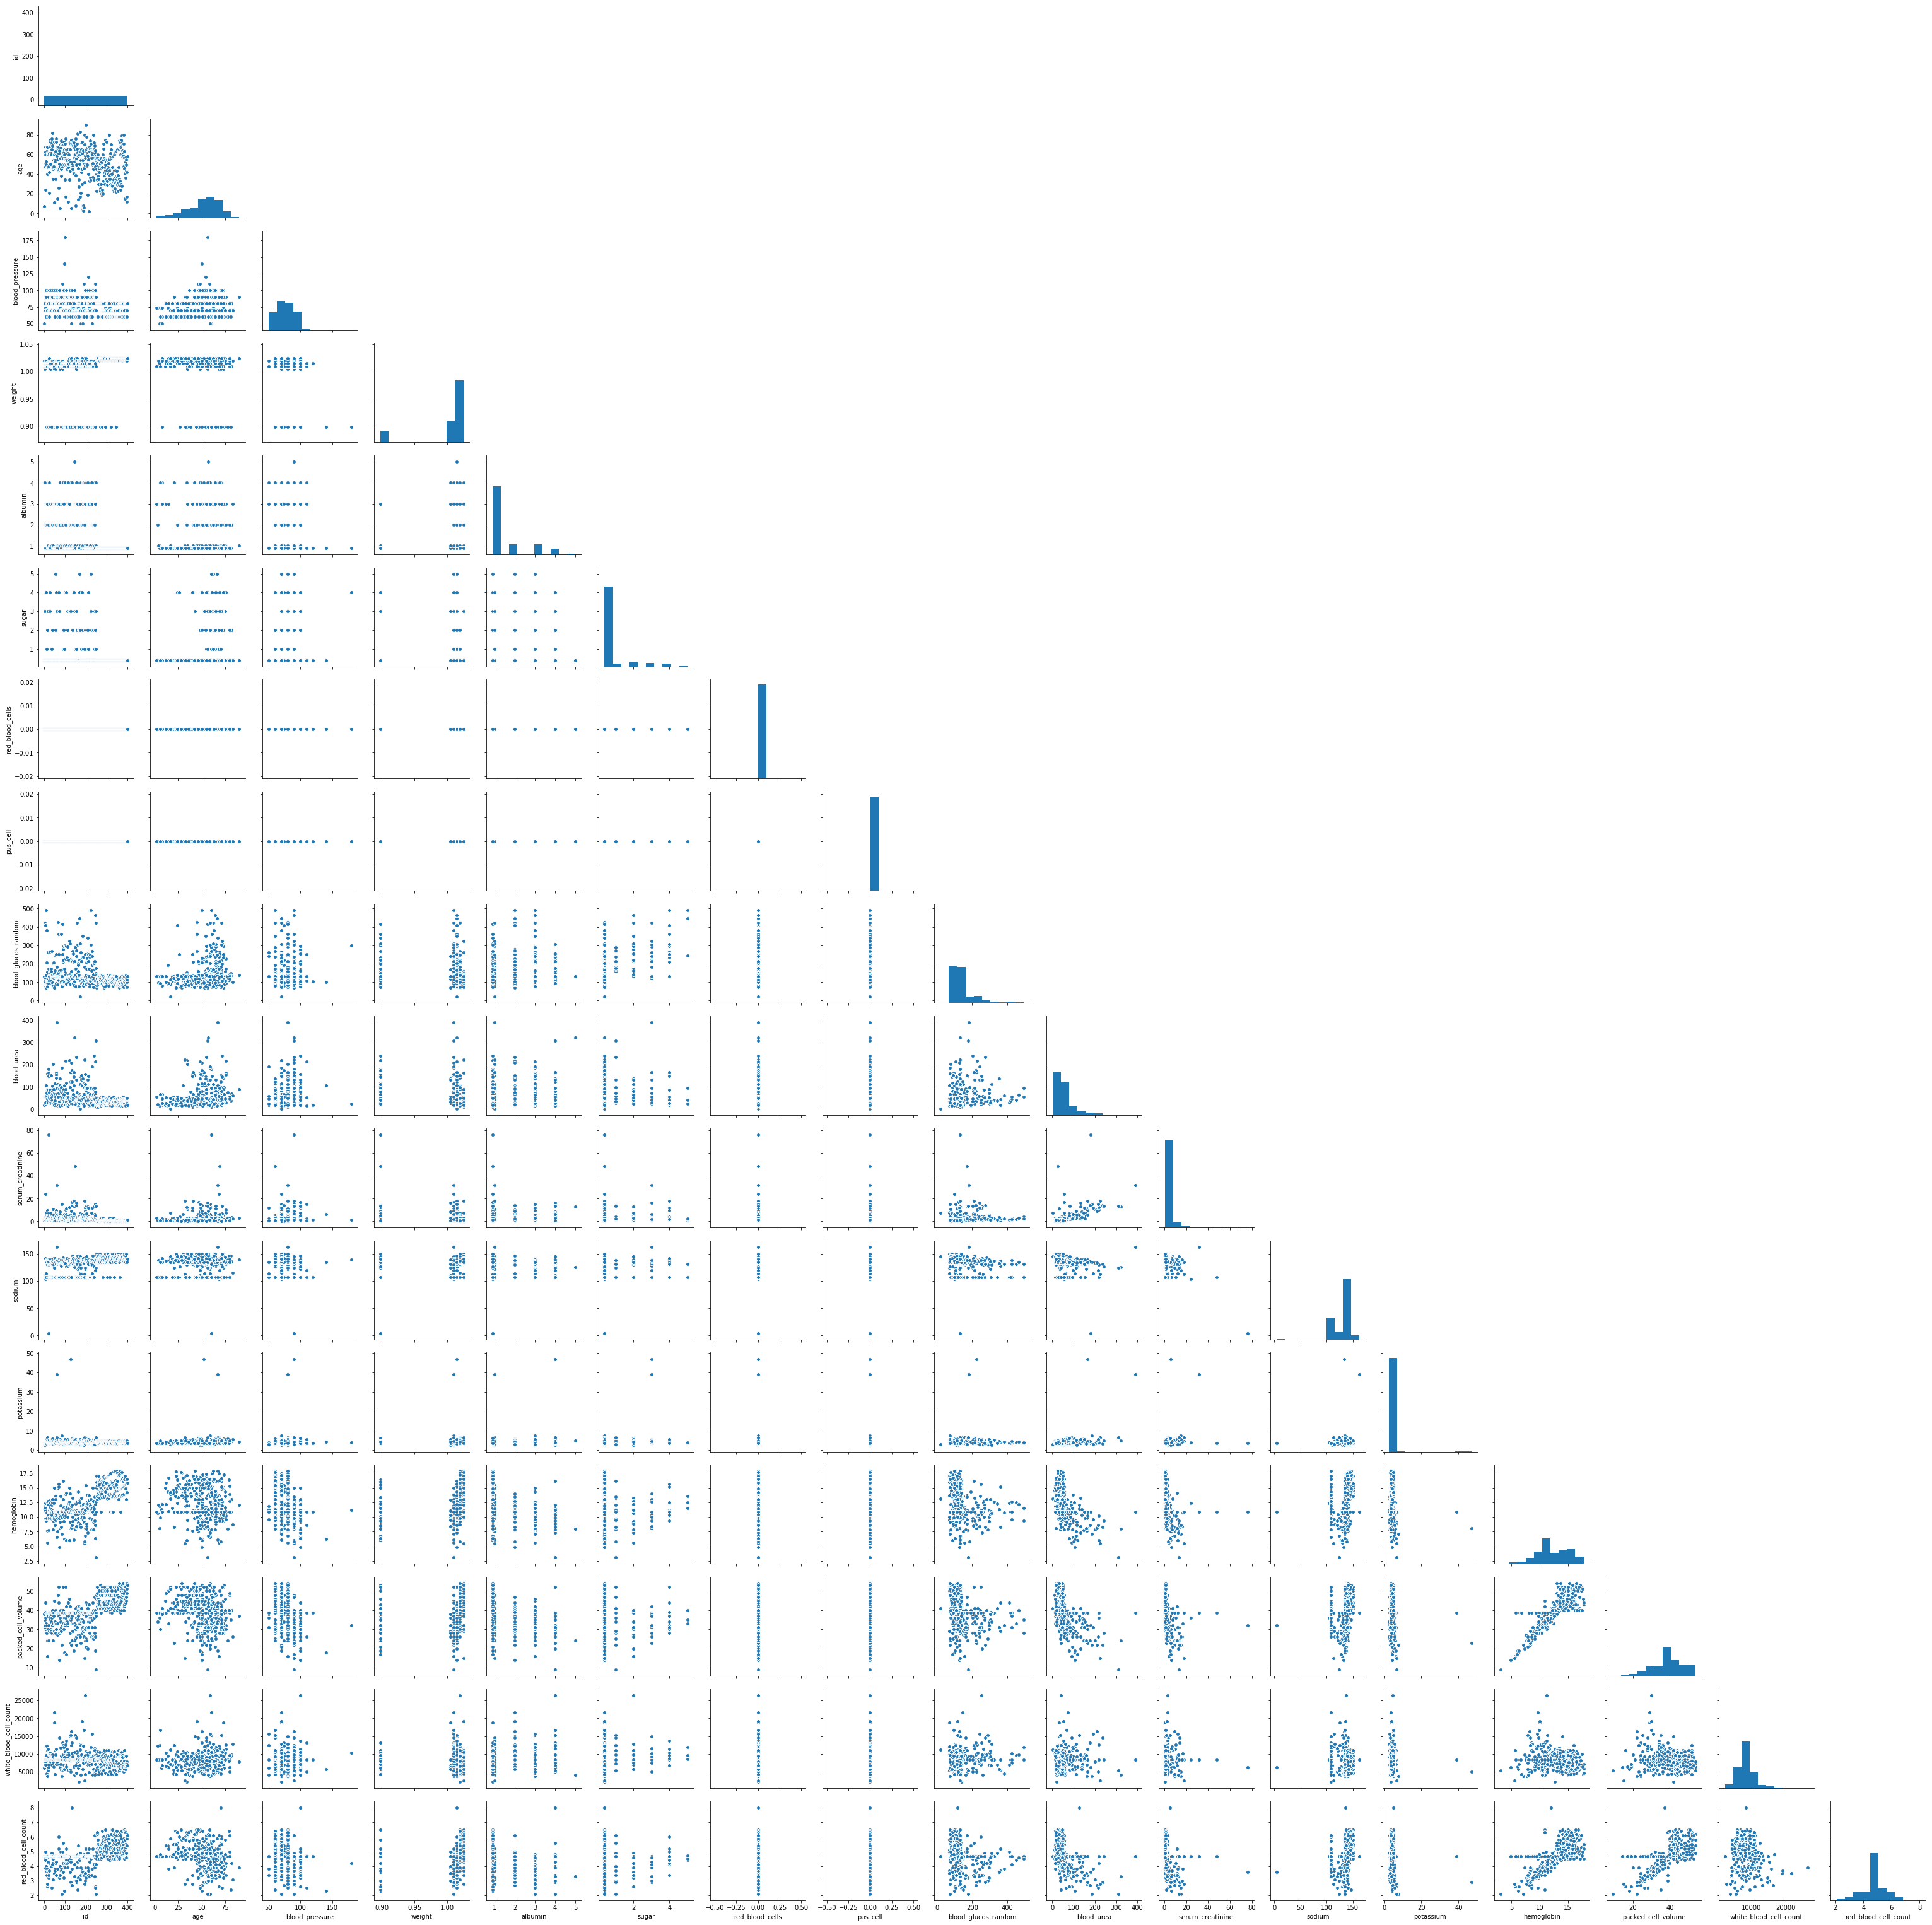

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.rcParams.update({'font.size': 25})

g = sns.pairplot(data, size=2.5)

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

## Boxplot


Some boxplots, of the data, here comes again the strength of plotly to hand, we can simply zoom in to whichever boxplot we would like to have a closer look, try it out:

In [ ]:
data.iplot(kind='box')